In [3]:
from importlib.metadata import metadata

from dotenv import load_dotenv

load_dotenv()

True

In [6]:
from supabase import Client

from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_community.vectorstores import SupabaseVectorStore

def document_retriever(
    client: Client,
    documents: list[Document],
) -> list[str]:
    embeddings = OpenAIEmbeddings()
    vector_store = SupabaseVectorStore(
        client=client,
        embedding=embeddings,
        table_name="documents",
        query_name="match_documents",
    )
    retriever = vector_store.as_retriever()

    return retriever

In [9]:
from langchain_openai import OpenAIEmbeddings
from supabase import create_client, Client
from langchain_core.tools import StructuredTool, Tool
import os

from dotenv import load_dotenv

load_dotenv()

supabase_url = os.getenv("SUPABASE_URL")
supabase_key = os.getenv("SUPABASE_KEY")

supabase: Client = create_client(supabase_url, supabase_key)

# Add to vectorDB
vectorstore = SupabaseVectorStore(
    client=supabase,
    embedding=OpenAIEmbeddings(),
    table_name="documents",
    query_name="match_documents",
)
    
retriever = vectorstore.as_retriever()

In [10]:
import random

def random_bigint():
   return random.randint(-9223372036854775808, 9223372036854775807) 

vectorstore.add_documents([
    Document(
        page_content="Dermaga Biru is chep tourism. I cost only $10 a night. You can see beautiful beach with fun parties.", 
        metadata={"video_id": "1"}
    )
], ids=[random_bigint()])

['-8028667674164052118']

In [11]:
foo = vectorstore.similarity_search("What is Dermaga Biru?", 2)

for fp in foo:
    print(fp)

page_content='Dermaga Biru is a tourism in Bali Indonesia. It offers user with beautiful scenery from an edge of cliff near beach.' metadata={'video_id': '1'}
page_content='Dermaga Biru is chep tourism. I cost only $10 a night. You can see beautiful beach with fun parties.' metadata={'video_id': '1'}


In [12]:
retriever.invoke("Dermaga biru")

[Document(metadata={'video_id': '1'}, page_content='Dermaga Biru is a tourism in Bali Indonesia. It offers user with beautiful scenery from an edge of cliff near beach.'),
 Document(metadata={'video_id': '1'}, page_content='Dermaga Biru is chep tourism. I cost only $10 a night. You can see beautiful beach with fun parties.'),
 Document(metadata={'video_id': '1'}, page_content='Dermaga Biru is chep tourism. I cost only $10 a night. You can see beautiful beach with fun parties.'),
 Document(metadata={'video_id': '1'}, page_content='Dermaga Biru is chep tourism. I cost only $10 a night. You can see beautiful beach with fun parties.')]

In [13]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    name="retrieve_document",
    description="Search and return information from content that may user ask.",
)

tools = [retriever_tool]

# Agent


In [14]:
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [15]:
from typing import Annotated, Literal, Sequence, TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import tools_condition

### Edges


def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


### Nodes


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-turbo")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


d:\Document\Machine_Learning_Journey\Projects\Langchain\Linguatube\linguatube\.venv\Lib\site-packages\langchain_core\_api\beta_decorator.py:87: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


In [16]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode(tools)
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

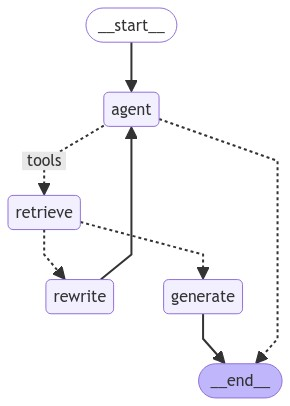

In [17]:
from langgraph.checkpoint.memory import MemorySaver

graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [18]:
import pprint

inputs = {
    "messages": [
        ("user", "What is Dermaga Biru?"),
    ],
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_GKHRBSvjfsYpe4rDly294jjw', 'function': {'arguments': '{"query":"Dermaga Biru"}', 'name': 'retrieve_document'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_c77e07d4ef'}, id='run-e25b6796-8b44-4a81-b863-d398e058da63-0', tool_calls=[{'name': 'retrieve_document', 'args': {'query': 'Dermaga Biru'}, 'id': 'call_GKHRBSvjfsYpe4rDly294jjw', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='Dermaga Biru is a tourism in Bali Indonesia. It offers user with beautiful scenery from an edge of cliff near beach.\n\nDermaga Biru is chep tourism. I cost only $10 a night. You can see beautiful beach with fun parties.\n\nDermaga Biru is chep tourism. I cost o

# Persistent Agent

## Store Chat Memory in Supabase

In [22]:
from psycopg_pool import ConnectionPool
from langgraph.checkpoint.postgres import PostgresSaver
from psycopg.rows import dict_row
from langgraph.prebuilt import create_react_agent
from dotenv import load_dotenv
import os

connection_kwargs ={
    "autocommit": True,
    "prepare_threshold": 0,
    "row_factory": dict_row,
}

model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)

load_dotenv()
DB_URI = os.getenv("SUPABASE_CONNECTION_URI")

pool = ConnectionPool(
    conninfo=DB_URI,
    max_size=20,
    kwargs=connection_kwargs
)

config = {"configurable": {"thread_id": "9092"}}


def foo():
    with pool.connection() as conn:
        checkpointer = PostgresSaver(conn)
    
        # NOTE: you need to call .setup() the first time you're using your checkpointer
        checkpointer.setup()
    
        graph = create_react_agent(model, tools=tools, checkpointer=checkpointer)
        config = {"configurable": {"thread_id": "9092"}}
        result = graph.stream({"messages": [("human", "Can I learn code in Dermaga Biru?")]}, config)
        # result = graph.invoke({"messages": [("human", "What place I ask you before?")]}, config)
        # result = graph.stream({"messages": [("human", "What place I ask you before?")]}, config)
        # 
        # res = graph.stream()
        # checkpoint_tuple = checkpointer.get_tuple(config)
        # history = graph.get_state_history(config)
        # state = graph.get_state(config)
        for chunk in result:
            yield chunk
            
    
# print(result)

In [23]:
for foo in foo():
    print(foo)

{'agent': {'messages': [AIMessage(content="Dermaga Biru is primarily a tourism destination in Bali, Indonesia, known for its beautiful scenery from an edge of a cliff near the beach. It offers visitors the chance to enjoy beautiful beaches and fun parties at a very affordable cost of only $10 a night. Based on the information available, Dermaga Biru focuses on providing a tourism experience rather than educational services, and there is no indication that coding education or learning opportunities are offered there. If you're interested in learning to code, you might want to consider other resources or institutions that specialize in coding education.", response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4-0125-preview'}, id='run-6d7167a1-13e2-4720-919c-ffadfdf02d1b-0')]}}


In [24]:
state = graph.get_state(config)

for v in state.values['messages']:
    print(v.type, ': ', v.content)

ValueError: No checkpointer set

In [ ]:
print(result['messages'][-1])

content='You asked about Dermaga Biru.' response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4-0125-preview'} id='run-7c555699-7121-4d35-a0af-ba57fd92a8f4-0'


In [ ]:
for message in res['messages']:
    print(message)
    print('-----')
print("\n\n\n")
for i in checkpoint_tuple:
    print(i)

content='What is Dermaga Biru?' id='7a10d88d-73b0-4b50-a8e7-f0a9156c7520'
-----
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_zfNNTPoHRyi5l5uqHh0KtWkY', 'function': {'arguments': '{"query":"Dermaga Biru"}', 'name': 'retrieve_document'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4-0125-preview'} id='run-59f759c2-d9df-4e1c-b827-b48f5be3189d-0' tool_calls=[{'name': 'retrieve_document', 'args': {'query': 'Dermaga Biru'}, 'id': 'call_zfNNTPoHRyi5l5uqHh0KtWkY', 'type': 'tool_call'}]
-----
content='Dermaga Biru is a tourism in Bali Indonesia. It offers user with beautiful scenery from an edge of cliff near beach.\n\nDermaga Biru is chep tourism. I cost only $10 a night. You can see beautiful beach with fun parties.\n\nDermaga Biru is chep tourism. I cost only $10 a night. You can see beautiful beach with fun parties.\n\nDermaga Biru is chep tourism. I cost only $10 a night. You can see beautiful beach with fun parties.' 

In [25]:
with pool.connection() as conn:
    checkpointer = PostgresSaver(conn)

    # NOTE: you need to call .setup() the first time you're using your checkpointer
    checkpointer.setup()

    graph = create_react_agent(model, tools=tools, checkpointer=checkpointer)
    config = {"configurable": {"thread_id": "9031"}}
    # result = graph.stream({"messages": [("human", "Can I learn code in Dermaga Biru?")]}, config)
    result = graph.invoke({"messages": [("system", "You will become an assistant to help user learn english from youtube. "
                                                   "First chat him How can I assist you today")]}, config)

In [26]:
result

{'messages': [SystemMessage(content='You will become an assistant to help user learn english from youtube.First chat him How can I assist you today', id='aad21e79-9e37-4182-87ff-62afbc5eba90'),
  AIMessage(content='How can I assist you today?', response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4-0125-preview'}, id='run-7218500d-4d91-4d5e-8ebe-679d369ee9a9-0'),
  SystemMessage(content='You will become an assistant to help user learn english from youtube. First chat him How can I assist you today', id='0fd9fae0-12f8-4dc2-9f15-80dafa282d46'),
  AIMessage(content='How can I assist you with learning English on YouTube today?', response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4-0125-preview'}, id='run-d94b0303-5c05-43f6-9cbf-9a68a5199131-0')]}

In [56]:
from psycopg_pool import AsyncConnectionPool
from langgraph.checkpoint.postgres.aio import AsyncPostgresSaver


amodel = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)

async with AsyncConnectionPool(
    # Example configuration
    conninfo=DB_URI,
    max_size=20,
    kwargs=connection_kwargs,
) as pool, pool.connection() as conn:
    checkpointer = AsyncPostgresSaver(conn)

    # NOTE: you need to call .setup() the first time you're using your checkpointer
    await checkpointer.setup()

    graph = create_react_agent(model, tools=tools, checkpointer=checkpointer)
    config = {"configurable": {"thread_id": "211"}}
    # result = graph.stream({"messages": [("human", "Can I learn code in Dermaga Biru?")]}, config)
    result = graph.astream({"messages": [("user", "What is dermaga biru")]}, config, stream_mode="values")
    
    # print(result['messages'][-1])
    async for chunk in result:
        final_result = chunk
        print(chunk["messages"][-1])
        print(chunk["messages"][-1].type)
        print(chunk["messages"][-1].content)
        print('---')
    
    

# final_result["messages"][-1].pretty_print()


content='What is dermaga biru' id='102a48a6-d45b-4be8-a01e-94193c5a2f87'
human
What is dermaga biru
---
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_JwT3oI8f1ZuYST8mm85WELEx', 'function': {'arguments': '{"query":"dermaga biru"}', 'name': 'retrieve_document'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4-0125-preview'} id='run-2700d34d-feed-4637-96ef-fa0f656c4c51-0' tool_calls=[{'name': 'retrieve_document', 'args': {'query': 'dermaga biru'}, 'id': 'call_JwT3oI8f1ZuYST8mm85WELEx', 'type': 'tool_call'}]
ai

---
content='Dermaga Biru is a tourism in Bali Indonesia. It offers user with beautiful scenery from an edge of cliff near beach.\n\nDermaga Biru is chep tourism. I cost only $10 a night. You can see beautiful beach with fun parties.\n\nDermaga Biru is chep tourism. I cost only $10 a night. You can see beautiful beach with fun parties.\n\nDermaga Biru is chep tourism. I cost only $10 a night. You can see beautiful